In [22]:
%matplotlib notebook
from DataSets import *
from RegressionRun import *
#from MalardClient.MalardClient import MalardClient
#from MalardClient.DataSet import DataSet
#from MalardClient.BoundingBox import BoundingBox
#from MalardClient.DataSetQuery import DataSetQuery
#import datetime
#import os
#import numpy as np
#import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import seaborn as sns
import scipy

In [23]:
reg = RegressionRun(notebook=True)
# minT and maxT
bbx = reg.client.boundingBox(reg.inputDataSet)
minT = bbx.minT
maxT = bbx.maxT
# minX etc.
minX = 400000
maxX = 500000
minY = 0
maxY = 100000

bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)

results = reg.gridcellRegression(bbx_in)

11:36:39, MainThread 140049216825152: RegressionRun INFO Process started
11:36:39, MainThread 140049216825152: RegressionRun INFO Filtering dataset=parentDataSet=mtngla, datSet=ReadyHim2, region=himalayas with criteria [{'column': 'power', 'op': 'gt', 'threshold': 10000}, {'column': 'coh', 'op': 'gt', 'threshold': 0.6}, {'column': 'demDiff', 'op': 'lt', 'threshold': 100}, {'column': 'demDiffMad', 'op': 'lt', 'threshold': 10}, {'column': 'demDiff', 'op': 'gt', 'threshold': -100}, {'column': 'demDiffMad', 'op': 'gt', 'threshold': -10}, {'column': 'refDifference', 'op': 'gt', 'threshold': -150}, {'column': 'refDifference', 'op': 'lt', 'threshold': 150}, {'column': 'within_DataSet', 'op': 'gt', 'threshold': 1}]
11:36:40, MainThread 140049216825152: RegressionRun INFO Result message: status=Success, message=Success
11:36:40, MainThread 140049216825152: DataSets INFO Linear regression...
11:36:40, MainThread 140049216825152: DataSets INFO Robust regression...
11:36:40, MainThread 14004921682

In [15]:
filters = reg.config('filters')
result = reg.client.executeQuery(reg.inputDataSet, bbx_in, projections=[], filters=filters)
data = PointDataSet(result.resultFileName, reg.projection)
data.data.shape[0]

829

In [16]:
data.data.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'within_DataSet', 'refElevation', 'refDifference'],
      dtype='object')

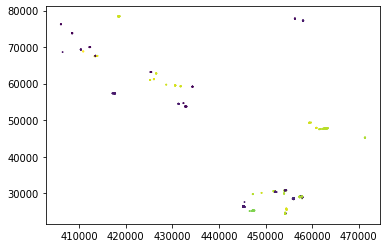

In [8]:
%matplotlib inline
plt.scatter(x=data.data.x,y=data.data.y, s=0.7, c=data.data.wf_number)

In [9]:
results

{'regression.rsquared': 0.004958838236633123,
 'regression.c': -2.57037671295777e-08,
 'regression.c.se': 1.2661191449355721e-08,
 'regression.c.year': -0.8105940001983624,
 'regression.c.se.year': 0.399283333546882,
 'regression.const': 25.214711186052167,
 'regression.const.se': 18.011530514986173,
 'regression.count': 829.0,
 'regression.const.pvalue': 0.1619121364724773,
 'regression.c.pvalue': 0.042663720622734005,
 'regression.const.tvalue': 1.3999205211946155,
 'regression.c.tvalue': -2.0301223018695973,
 'regression.c.conf_interval.low': -1.5943219579145693,
 'regression.c.conf_interval.high': -0.026866042482155333,
 'regression.const.conf_interval.low': -10.138980891345302,
 'regression.const.conf_interval.high': 60.56840326344964,
 'regression.robust.c': -2.329011850768183e-08,
 'regression.robust.c.se': 1.1520189649963635e-08,
 'regression.robust.c.year': -0.7344771772582542,
 'regression.robust.c.se.year': 0.3633007008012532,
 'regression.robust.const': 21.647558330918592,


In [17]:
filters = reg.config('filters')

queried_data = reg.client.executeQuery(reg.inputDataSet, bbx_in, projections=[], filters=filters)

data = PointDataSet(queried_data.resultFileName, reg.projection)
# release cache of file
reg.client.releaseCacheHandle(queried_data.resultFileName)

month = []
for i, row in data.data.iterrows():
    date = datetime.datetime.utcfromtimestamp(data.data.time[i])
    month.append(date.month)
data.data['month'] = month

results = {}
if data.data.shape[0]>2:
    # model variables
    vals = np.asarray([data.data.time])
    vals = np.transpose(vals)
    vals = sm.add_constant(vals)
    elev = data.data.refDifference

    # Create model and fit it (least squares)
    #model = sm.OLS(elev, vals)
    #results = model.fit()
    # OR robust model -- note that it won't have r squared
    #model = sm.RLM(elev, vals)
    # OR weithed model
    #weights = range(1,len(elev)+1)
    #weights = data.data.power
    # weights according to script
    power = data.data.power*data.data.power
    w = power/max(power)
    weights = w*w
    
    # mask huge elevation differences out
    mask = abs(elev-np.median(elev))>(3*np.std(elev))
    weights = np.where(mask,0,w)
    
    model = sm.WLS(elev, vals, weights)

    #results = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
    results = model.fit()

    regression_results = {}

    regression_results['regression.rsquared'] = results.rsquared
    regression_results['regression.c'] = results.params.x1
    regression_results['regression.c.se'] = results.bse.x1
    regression_results['regression.c.year'] = results.params.x1*31536000
    regression_results['regression.c.se.year'] = results.bse.x1*31536000
    regression_results['regression.const'] = results.params.const
    regression_results['regression.const.se'] = results.bse.const
    regression_results['regression.count'] = results.nobs
    
    regression_results['regression.const.pvalue'] = results.pvalues.const 
    regression_results['regression.c.pvalue'] = results.pvalues.x1 
    regression_results['regression.const.tvalue'] = results.tvalues.const 
    regression_results['regression.c.tvalue'] = results.tvalues.x1
    
    intervals = results.conf_int(alpha=0.05, cols=None)
    regression_results['regression.c.conf_interval.low'] = intervals[intervals.index=='x1'].values[0][0]*31536000
    regression_results['regression.c.conf_interval.high'] = intervals[intervals.index=='x1'][1].values[0]*31536000
    regression_results['regression.const.conf_interval.low'] = intervals[intervals.index=='const'][0].values[0]
    regression_results['regression.const.conf_interval.high'] = intervals[intervals.index=='const'][1].values[0]
    
    results.conf_int(alpha=0.05, cols=None)
    
    
    print(results.summary())

                            WLS Regression Results                            
Dep. Variable:          refDifference   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.406
Date:                Thu, 28 Nov 2019   Prob (F-statistic):              0.236
Time:                        14:56:14   Log-Likelihood:                   -inf
No. Observations:                 829   AIC:                               inf
Df Residuals:                     827   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.2205     18.468     -1.582      0.1

In [13]:
results.resid.std()

26.002801126052827

In [8]:
results.wresid

0       0.556855
1       0.258042
2      -0.441695
3      -1.250831
4      -0.086661
5      -1.737361
6      -2.701541
7      -4.049331
8      -4.985077
9      -4.571922
10     -3.199797
11     -2.046647
12      3.253699
13      2.546065
14      2.303328
15      4.570218
16      4.304400
17      3.619365
18      3.748243
19      9.029767
20     14.895346
21     26.109831
22     29.850868
23     21.608287
24     10.870770
25     16.223573
26     16.117876
27     10.195937
28      6.015223
29     -7.601586
         ...    
799     8.763569
800     7.907601
801     8.068335
802     9.666934
803     9.133080
804     6.367010
805     4.518784
806     3.968219
807     3.576614
808     3.215255
809     1.619626
810     0.694314
811     0.462763
812     0.392204
813     0.276861
814     0.165953
815    -1.302570
816    -2.848571
817     6.795692
818     7.490998
819     8.374737
820     8.303944
821    -9.136583
822   -15.067424
823   -21.571338
824   -30.108262
825   -34.797208
826   -28.3585

In [10]:
results.conf_int(alpha=0.32, cols=None)

,0,1
const,6.580724e+01,6.698306e+01
x1,-5.067903e-08,-4.984837e-08


In [142]:
intervals[intervals.index=='const'].values[0][0]
#intervals[intervals.index=='const'].values[0]

65.2364344533844

In [ ]:
print(results.get_robustcov_results(cov_type='HC3').summary())

In [7]:
res2 = model.fit(cov_type='HC0')
print(res2.summary())

                            WLS Regression Results                            
Dep. Variable:          refDifference   R-squared:                       0.117
Model:                            WLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7354.
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        07:59:02   Log-Likelihood:                   -inf
No. Observations:              109053   AIC:                               inf
Df Residuals:                  109051   BIC:                               inf
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.3951      0.821     80.880      0.0

In [80]:
pd.DataFrame([weights,data.data.power])

,0,1,2,3,4,5,6,7,8,9,...,819,820,821,822,823,824,825,826,827,828
0,0.073467,0.172515,0.225646,0.132030,0.052209,0.047307,0.107176,0.222858,0.321467,0.254794,...,0.164957,0.174972,0.101072,0.040734,0.096012,0.200489,0.274461,0.191194,0.084550,0.035200
1,14590.706055,22358.533203,25570.798828,19559.869141,12299.942383,11708.251953,17622.955078,25412.312500,30520.960938,27172.203125,...,21863.263672,22517.177734,17113.779297,10864.430664,16679.875000,24103.240234,28201.369141,23537.861328,15652.606445,10099.522461


In [18]:
regression_results

{'regression.rsquared': 0.0016966503392643606,
 'regression.c': 1.5380843831225152e-08,
 'regression.c.se': 1.2973654192681695e-08,
 'regression.c.year': 0.48505029106151637,
 'regression.c.se.year': 0.40913715862040995,
 'regression.const': -29.22046886698464,
 'regression.const.se': 18.46791323174918,
 'regression.count': 829.0,
 'regression.const.pvalue': 0.11397962650974171,
 'regression.c.pvalue': 0.23614277764450026,
 'regression.const.tvalue': -1.5822290531856174,
 'regression.c.tvalue': 1.185544458237628,
 'regression.c.conf_interval.low': -0.3180191155751024,
 'regression.c.conf_interval.high': 1.2881196976981353,
 'regression.const.conf_interval.low': -65.46996566372346,
 'regression.const.conf_interval.high': 7.029027929754186}

In [81]:
regression_results

{'regression.rsquared': 0.0016966503392643606,
 'regression.c': 1.5380843831225152e-08,
 'regression.c.se': 1.3076087761066814e-08,
 'regression.c.year': 0.48505029106151637,
 'regression.c.se.year': 0.41236750363300306,
 'regression.const': -29.22046886698464,
 'regression.const.se': 18.122543961752537,
 'regression.count': 829.0}

In [177]:
data.data.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'within_DataSet', 'refElevation', 'refDifference'],
      dtype='object')

In [20]:
# calculate regression prediction
minTime = data.data.time.min()
maxTime = data.data.time.max()
# calcualte prediction
minTimeValue = regression_results['regression.c']*minTime+regression_results['regression.const']
maxTimeValue = regression_results['regression.c']*maxTime+regression_results['regression.const']
predict_v = [minTimeValue,maxTimeValue]

# calculate upper error
minTimeValue = (regression_results['regression.c']+regression_results['regression.c.se'])*minTime+regression_results['regression.const']+regression_results['regression.const.se']
maxTimeValue = (regression_results['regression.c']+regression_results['regression.c.se'])*maxTime+regression_results['regression.const']+regression_results['regression.const.se']
predict_eup = [minTimeValue,maxTimeValue]

# calculate lower error
minTimeValue = (regression_results['regression.c']-regression_results['regression.c.se'])*minTime+regression_results['regression.const']-regression_results['regression.const.se']
maxTimeValue = (regression_results['regression.c']-regression_results['regression.c.se'])*maxTime+regression_results['regression.const']-regression_results['regression.const.se']
predict_elow = [minTimeValue,maxTimeValue]

<IPython.core.display.Javascript object>


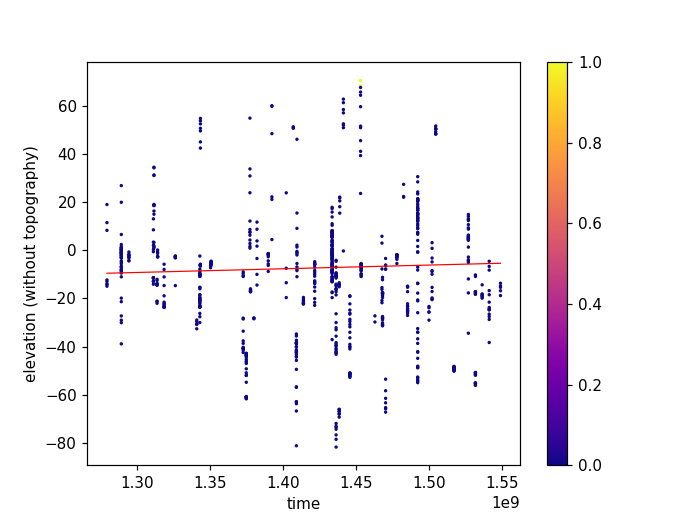

Text(0, 0.5, 'elevation (without topography)')

In [21]:
#data.data.plot(type='scatter',x='time', y='refDifference')
%matplotlib notebook

sc= plt.scatter(x=data.data.time, y=data.data.refDifference, c=mask, marker='.', s=6, cmap='plasma')
plt.colorbar(sc)
plt.plot([minTime,maxTime], predict_v, color='red', linewidth=0.8)
#plt.plot([minTime,maxTime], predict_elow, color='red', linewidth=0.8)
#plt.plot([minTime,maxTime], predict_eup, color='red', linewidth=0.8)
#plt.xlim(-50,50)
plt.xlabel('time')
plt.ylabel('elevation (without topography)')

<IPython.core.display.Javascript object>


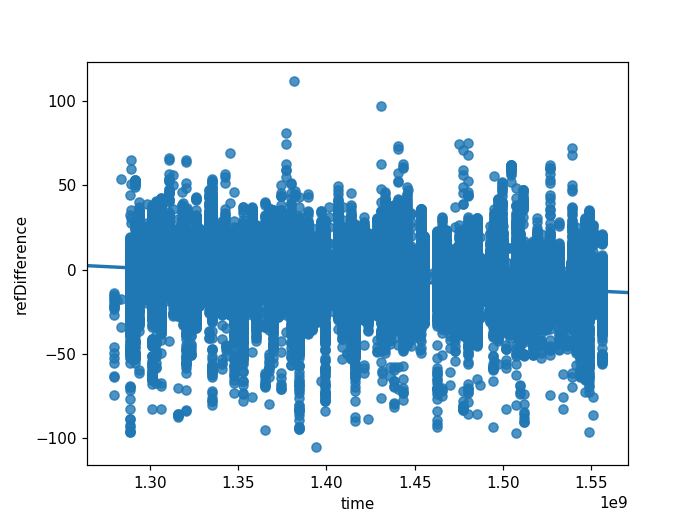

In [14]:
import seaborn as sns
%matplotlib notebook
sns.regplot(data.data.time, data.data.refDifference)

In [32]:
data.data.refDifference.std(), data.data.refDifference.sem()

(25.90313328934759, 0.899653005220245)

In [36]:
math.sqrt(pow(regression_results['regression.c.se.year'],2)+pow(data.data.refDifference.sem(),2))

0.9883161156056298

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
# generate random data
np.random.seed(24)
x = np.random.uniform(-5,5,25)
ϵ = 2*np.random.randn(25)
y = 2*x+ϵ

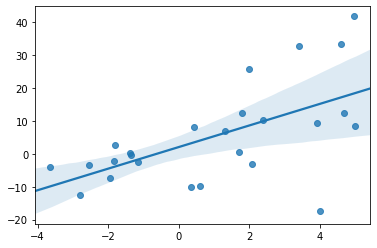

In [28]:
# alternate error as a function of x
ϵ2 = ϵ*(x+5)
y2 = 2*x+ϵ2
#sns.regplot(x,y2);
sns.regplot(x,y2,x_ci='sd');

In [17]:
# diagonal of weights
diag = scipy.sparse.diags(weights, 0, dtype=float)
diag.toarray()

array([[0.07346696, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17251469, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22564621, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19119366, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08454984,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03519988]])

In [18]:
# transpose of elevation
dep=np.mat(data.data.elev).T

In [19]:
indep=np.mat([list(data.data.time),list(np.ones(data.data.elev.size)), list(data.data.power)]).T
#indep=np.mat(data.data.time).T

In [20]:
#diag = scipy.sparse.diags([0.5,0.25,0.5], 0, dtype=float)
weights = diag.toarray()
#indep = np.mat([1,2,3]).T
#dep = np.mat([150,300,400]).T
#weights, dep, indep
indep.size, dep.size, weights.size, weights[0].size

(2487, 829, 687241, 829)

In [22]:
# G is matrix of indep
# d is transposed elevation matrix
# w is diagonals matrix of weights

# compute the inverse of the model matrix
wsqrt = np.sqrt(weights)

In [23]:
G_inv = np.linalg.pinv(wsqrt*indep)*wsqrt
#G_inv
# compute the model coefficients
coeff = G_inv*dep

d_modelled = indep*coeff
d_diff = dep-d_modelled
d_diff = d_diff*d_diff.T
varData = np.diag(np.diag(d_diff))
# calculate unit model covariance matrix
cov_matrix = G_inv*varData*G_inv.T

#return (coeff, cov_matrix)
cov_matrix, coeff

(matrix([[ 9.90486083e-15, -1.40336885e-05, -3.89694092e-12],
         [-1.40336885e-05,  2.01158406e+04, -2.08152509e-03],
         [-3.89694092e-12, -2.08152509e-03,  2.97939922e-07]]),
 matrix([[-2.65366229e-07],
         [ 5.53000253e+03],
         [ 3.61821786e-03]]))

In [24]:

error=np.sqrt(np.diag(cov_matrix)[0])*31536000

rate=coeff[0,0]*31536000
print(error, rate)

3.1385626041064136 -8.368589411091493


In [13]:
x = np.array([1, 2, 3, 4])
y = np.array([4.1, 5.8, 8.1, 9.7])
dy = np.array([0.2, 0.3, 0.2, 0.4]) 

#Calculate Chi^2 function to minimize
def chi_2(params,x,y,sigy):
    m,c=params
    return sum(((y-m*x-c)/sigy)**2)

data_in=(x,y,dy)
params0=[1,0]

q=fmin(chi_2,params0,args=data_in)

Optimization terminated successfully.
         Current function value: 1.283688
         Iterations: 77
         Function evaluations: 147


Optimization terminated successfully.
         Current function value: 1.283688
         Iterations: 77
         Function evaluations: 147


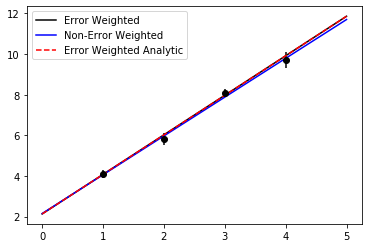

In [12]:
import numpy as np
from scipy.optimize import fmin

x = np.array([1, 2, 3, 4])
y = np.array([4.1, 5.8, 8.1, 9.7])
dy = np.array([0.2, 0.3, 0.2, 0.4]) 

#Calculate Chi^2 function to minimize
def chi_2(params,x,y,sigy):
    m,c=params
    return sum(((y-m*x-c)/sigy)**2)

data_in=(x,y,dy)
params0=[1,0]

q=fmin(chi_2,params0,args=data_in)

#Unweighted fit to compare

a=np.polyfit(x,y,deg=1)

#Analytic solution
sx=sum(x/dy**2)
sx2=sum(x**2/dy**2)
s1=sum(1./dy**2)
sy=sum(y/dy**2)
sxy=sum(x*y/dy**2)

ma=(s1*sxy-sx*sy)/(s1*sx2-sx**2)
ba=(sx2*sy-sx*sxy)/(sx2*s1-sx**2)

xplt=np.linspace(0,5,100)
yplt1=xplt*q[0]+q[1]


yplt2=xplt*a[0]+a[1]

yplt3=xplt*ma+ba

plt.figure()
plt.plot(xplt,yplt1,label='Error Weighted',color='black')
plt.plot(xplt,yplt2,label='Non-Error Weighted',color='blue')
plt.plot(xplt,yplt3,label='Error Weighted Analytic',linestyle='--',color='red')
plt.errorbar(x,y,yerr=dy,fmt='ko')
plt.legend()
plt.show()

NameError: name 'boundingBox' is not defined